# Cell 1: Install & Import Necessary Libraries

In [1]:
# Install necessary libraries
#!pip install transformers torch pandas scikit-learn matplotlib seaborn numpy wordcloud

# Import libraries
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# DistilBERT-specific imports (replacing RoBERTa)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# Updated imports for optimizer and scheduler
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

# Cell 2: Load the Dataset

In [2]:
# Load the resume.csv file
df = pd.read_csv("f:\\CSE499A,B\\New 499B\\final works\\graph generation\\Datasets\\Resume\\Resume.csv")

# Display the first few rows
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Cell 3: Check for Missing Data & Basic Info

In [3]:
# Check for missing values
print(df.isnull().sum())

# Display dataset information
df.info()

# Drop rows with missing values (if any)
df.dropna(inplace=True)


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


# Cell 4: Advanced Text Preprocessing Function

In [4]:
def preprocess_text_for_bert(text):
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # BERT will handle the rest of tokenization
    return text

# Apply minimal preprocessing to 'resume_str'
df['processed_resume'] = df['Resume_str'].apply(preprocess_text_for_bert)

# Display sample processed text
df[['Resume_str', 'processed_resume']].head()

,Resume_str,processed_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...
1,"HR SPECIALIST, US HR OPERATIONS ...","HR SPECIALIST, US HR OPERATIONS Summary Versat..."
2,HR DIRECTOR Summary Over 2...,HR DIRECTOR Summary Over 20 years experience i...
3,HR SPECIALIST Summary Dedica...,"HR SPECIALIST Summary Dedicated, Driven, and D..."
4,HR MANAGER Skill Highlights ...,HR MANAGER Skill Highlights HR SKILLS HR Depar...


# Cell 5: Data Visualization (Optional - needs WordCloud import)


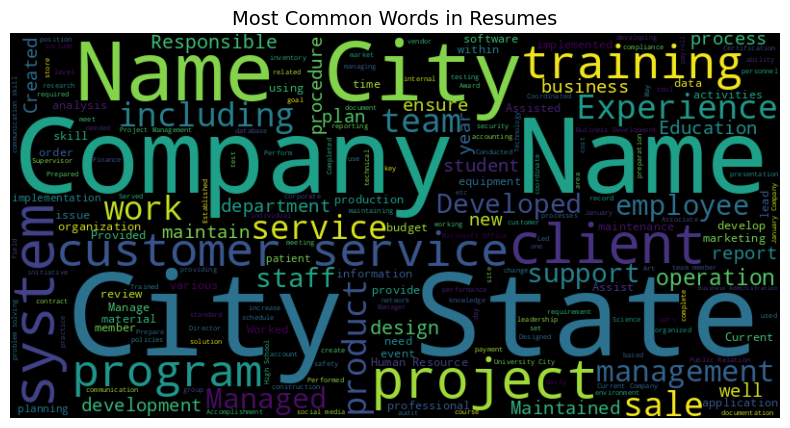

In [5]:
from wordcloud import WordCloud

# Generate a WordCloud to visualize frequent words
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(' '.join(df['processed_resume']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Resumes", fontsize=14)
plt.show()

# Cell 6: Convert Categories to Numeric Labels

In [6]:
# Encode categories into numeric labels
label_encoder = LabelEncoder()
df['Category_label'] = label_encoder.fit_transform(df['Category'])

# Display mapping of labels
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Category mapping:")
for category, label in category_mapping.items():
    print(f"{category}: {label}")

Category mapping:
ACCOUNTANT: 0
ADVOCATE: 1
AGRICULTURE: 2
APPAREL: 3
ARTS: 4
AUTOMOBILE: 5
AVIATION: 6
BANKING: 7
BPO: 8
BUSINESS-DEVELOPMENT: 9
CHEF: 10
CONSTRUCTION: 11
CONSULTANT: 12
DESIGNER: 13
DIGITAL-MEDIA: 14
ENGINEERING: 15
FINANCE: 16
FITNESS: 17
HEALTHCARE: 18
HR: 19
INFORMATION-TECHNOLOGY: 20
PUBLIC-RELATIONS: 21
SALES: 22
TEACHER: 23


# Cell 7: Train-Test Split

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_resume'], 
    df['Category_label'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['Category_label']
)

# Print dataset shapes
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 1987, Testing samples: 497


# Cell 8: Create BERT Dataset and DataLoader

In [8]:
# Load DistilBERT tokenizer (replacing RoBERTa tokenizer)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Maximum sequence length for DistilBERT
MAX_LEN = 256

class ResumeDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        
        # Tokenize and prepare for DistilBERT
        encoding = tokenizer(
            text,
            truncation=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = ResumeDataset(X_train, y_train)
test_dataset = ResumeDataset(X_test, y_test)

# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created DistilBERT datasets with {len(train_dataset)} training and {len(test_dataset)} testing samples")

Created DistilBERT datasets with 1987 training and 497 testing samples


# Cell 9: Updated Model Initialization  and Train DistilBERT Model

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 completed
Saved best model to distilbert_resume_best_model
Epoch 2/20 completed
Saved best model to distilbert_resume_best_model
Epoch 3/20 completed
Saved best model to distilbert_resume_best_model
Epoch 4/20 completed
Saved best model to distilbert_resume_best_model
Epoch 5/20 completed
Saved best model to distilbert_resume_best_model
Epoch 6/20 completed
Saved best model to distilbert_resume_best_model
Epoch 7/20 completed
Saved best model to distilbert_resume_best_model
Epoch 8/20 completed
Saved best model to distilbert_resume_best_model
Epoch 9/20 completed
Saved best model to distilbert_resume_best_model
Epoch 10/20 completed
Saved best model to distilbert_resume_best_model
Epoch 11/20 completed
Saved best model to distilbert_resume_best_model
Epoch 12/20 completed
Saved best model to distilbert_resume_best_model
Epoch 13/20 completed
Saved best model to distilbert_resume_best_model
Epoch 14/20 completed
Saved best model to distilbert_resume_best_model
Epoch 15/20 com

,Epoch,Training Loss,Validation Loss
0,1,2.740008,1.911519
1,2,1.496378,1.055782
2,3,0.945700,0.751967
3,4,0.704248,0.616865
4,5,0.536400,0.442691
5,6,0.424739,0.359459
6,7,0.340223,0.278620
7,8,0.273133,0.223422
8,9,0.206248,0.150701
9,10,0.164275,0.120925


,Epoch,Training Loss,Validation Loss
0,1,2.740008,1.911519
1,2,1.496378,1.055782
2,3,0.945700,0.751967
3,4,0.704248,0.616865
4,5,0.536400,0.442691
5,6,0.424739,0.359459
6,7,0.340223,0.278620
7,8,0.273133,0.223422
8,9,0.206248,0.150701
9,10,0.164275,0.120925


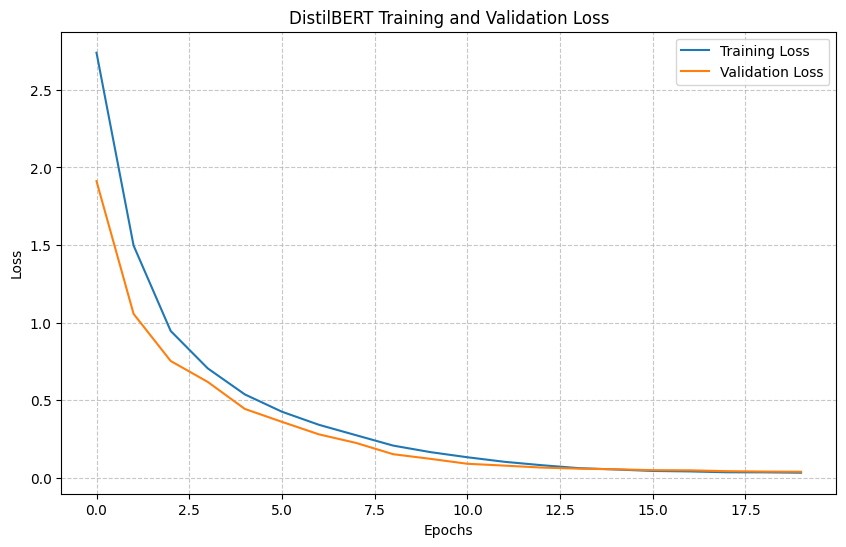

In [9]:
# Initialize and Train DistilBERT Model
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize DistilBERT model
num_classes = len(df['Category_label'].unique())
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_classes
)
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 20

# Total steps for scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# For early stopping
best_val_loss = float('inf')
patience = 3
early_stop_counter = 0
val_losses = []
train_losses = []

# For tracking all epoch results
epoch_results = []

# Split training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create validation dataset and dataloader
val_dataset = ResumeDataset(val_texts, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Zero gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    # Print just a simple message during training to avoid cluttering output
    print(f"Epoch {epoch+1}/{epochs} completed")
    
    # Store epoch results
    epoch_results.append({
        'Epoch': epoch+1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
    })
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        # Save the best model
        best_model_path = "distilbert_resume_best_model"
        model.save_pretrained(best_model_path)
        print(f"Saved best model to {best_model_path}")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        
    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

# Convert epoch results to DataFrame and display
epoch_df = pd.DataFrame(epoch_results)
print("\nComplete Training History:")
display(epoch_df)

# Apply styling to the DataFrame (optional)
styled_epoch_df = epoch_df.style.background_gradient(cmap='Blues', subset=['Training Loss', 'Validation Loss'])\
                             .format(precision=6)
display(styled_epoch_df)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('DistilBERT Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Cell 10: Evaluate the DistilBERT Model

Accuracy: 0.8008
Classification Report as Table:


,precision,recall,f1-score,support
ACCOUNTANT,1.00,1.00,1.00,24.00
ADVOCATE,0.79,0.92,0.85,24.00
AGRICULTURE,0.62,0.77,0.69,13.00
APPAREL,0.41,0.37,0.39,19.00
ARTS,0.52,0.57,0.55,21.00
AUTOMOBILE,0.20,0.14,0.17,7.00
AVIATION,0.89,0.67,0.76,24.00
BANKING,0.71,0.74,0.72,23.00
BPO,0.33,0.50,0.40,4.00
BUSINESS-DEVELOPMENT,0.89,1.00,0.94,24.00


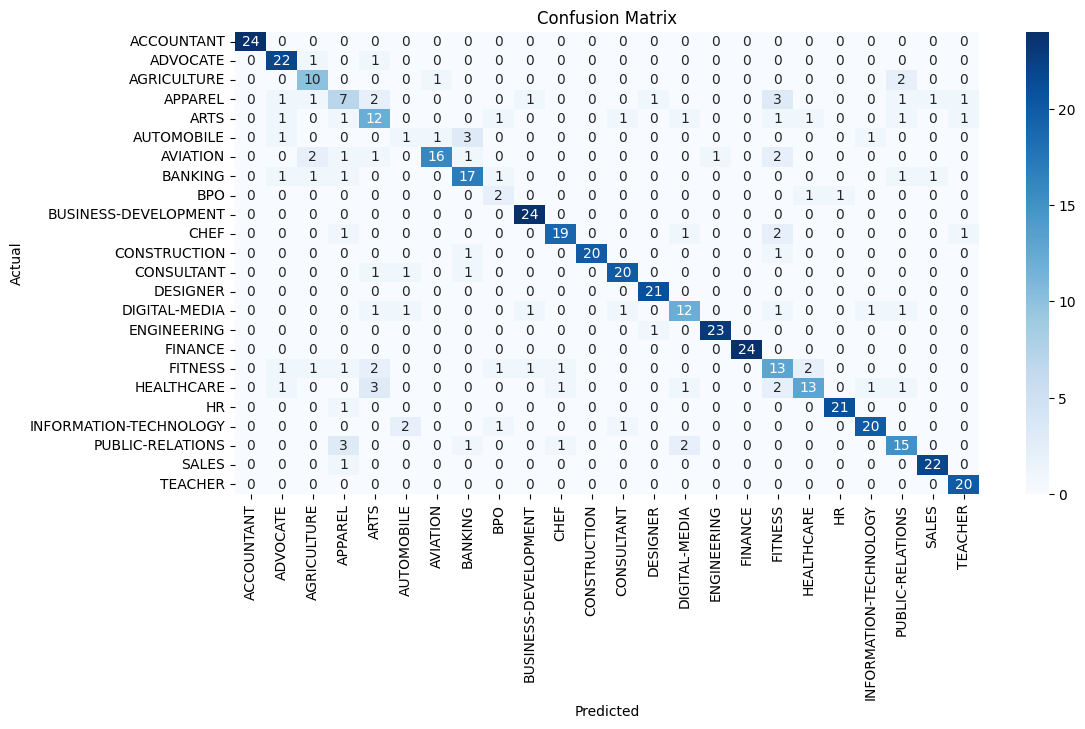

In [10]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get predictions
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Store predictions and true labels
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
# Enhanced Classification Report (replaces the simple print in Cell 10)
from sklearn.metrics import classification_report

# Get the classification report as a dictionary
report = classification_report(true_labels, predictions, 
                              target_names=label_encoder.classes_, 
                              output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Apply styling to the DataFrame
styled_report = report_df.style.background_gradient(cmap='Blues', subset=pd.IndexSlice[:, ['precision', 'recall', 'f1-score']])\
                               .format(precision=2)

# Display the styled report
print("Classification Report as Table:")
display(styled_report)

# If display() doesn't work in your environment, use this instead:
# print(report_df.round(2).to_string())

# Confusion Matrix
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Cell 11: Precision, Recall, F1-score

In [11]:
# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

# Print metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8021
Recall: 0.8008
F1 Score: 0.7985


# Cell 12: Enhanced Evaluation Metrics

In [12]:
# New Cell: Additional Performance Metrics
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate additional metrics
mcc = matthews_corrcoef(true_labels, predictions)
kappa = cohen_kappa_score(true_labels, predictions)

# For ROC-AUC in multi-class setting
classes = np.unique(true_labels)
y_bin = label_binarize(true_labels, classes=classes)
y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(
    input_ids=test_dataloader.dataset[0]['input_ids'].unsqueeze(0).to(device),
    attention_mask=test_dataloader.dataset[0]['attention_mask'].unsqueeze(0).to(device)
).logits.detach().cpu()), dim=1).numpy()

try:
    roc_auc = roc_auc_score(y_bin, y_pred_proba, multi_class='ovr')
    print(f"ROC-AUC Score (OvR): {roc_auc:.4f}")
except:
    print("ROC-AUC calculation requires predicted probabilities for all samples.")

print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

# Per-class metrics
per_class_precision = precision_score(true_labels, predictions, average=None)
per_class_recall = recall_score(true_labels, predictions, average=None)
per_class_f1 = f1_score(true_labels, predictions, average=None)

# Create DataFrame for per-class metrics
class_metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': per_class_precision,
    'Recall': per_class_recall,
    'F1-Score': per_class_f1
})

print("\nPer-Class Metrics:")
print(class_metrics_df.to_string(index=False))

ROC-AUC calculation requires predicted probabilities for all samples.
Matthews Correlation Coefficient: 0.7919
Cohen's Kappa: 0.7916

Per-Class Metrics:
                 Class  Precision   Recall  F1-Score
            ACCOUNTANT   1.000000 1.000000  1.000000
              ADVOCATE   0.785714 0.916667  0.846154
           AGRICULTURE   0.625000 0.769231  0.689655
               APPAREL   0.411765 0.368421  0.388889
                  ARTS   0.521739 0.571429  0.545455
            AUTOMOBILE   0.200000 0.142857  0.166667
              AVIATION   0.888889 0.666667  0.761905
               BANKING   0.708333 0.739130  0.723404
                   BPO   0.333333 0.500000  0.400000
  BUSINESS-DEVELOPMENT   0.888889 1.000000  0.941176
                  CHEF   0.863636 0.791667  0.826087
          CONSTRUCTION   1.000000 0.909091  0.952381
            CONSULTANT   0.869565 0.869565  0.869565
              DESIGNER   0.913043 1.000000  0.954545
         DIGITAL-MEDIA   0.705882 0.631579  0.666667

C:\Users\USER\AppData\Local\Temp\ipykernel_10844\2328198840.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_proba = torch.nn.functional.softmax(torch.tensor(model(


# Cell 13: Misclassification Analysis

In [13]:
# New Cell: Misclassification Analysis
# Find misclassified examples
misclassified_indices = np.where(np.array(predictions) != np.array(true_labels))[0]

# Sample up to 10 misclassified examples
sample_size = min(10, len(misclassified_indices))
sampled_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

print(f"\nMisclassification Analysis (Showing {sample_size} examples):")
for idx in sampled_indices:
    actual_label = label_encoder.inverse_transform([true_labels[idx]])[0]
    predicted_label = label_encoder.inverse_transform([predictions[idx]])[0]
    
    # Get the corresponding text from the test set
    text_idx = X_test.index[idx]
    text = X_test.iloc[idx][:100] + "..."  # Show first 100 chars
    
    print(f"\nExample {idx}:")
    print(f"Text: {text}")
    print(f"Actual: {actual_label}")
    print(f"Predicted: {predicted_label}")
    print("-" * 50)


Misclassification Analysis (Showing 10 examples):

Example 259:
Text: TAX COLLECTOR OFFICER Professional Summary Entrepreneurial Marketing Officer passionate about buildi...
Actual: PUBLIC-RELATIONS
Predicted: BANKING
--------------------------------------------------

Example 400:
Text: EXECUTIVE ASSISTANT/OFFICE MANAGER Summary Continue to manage employees to perform their best, while...
Actual: FITNESS
Predicted: APPAREL
--------------------------------------------------

Example 370:
Text: MANAGEMENT CONSULTANT Summary Human capital manager and operations strategist who works with cross-f...
Actual: CONSULTANT
Predicted: AUTOMOBILE
--------------------------------------------------

Example 150:
Text: ACCOUNT EXECUTIVE Professional Summary Account Executive Accomplished sales-management professional ...
Actual: AVIATION
Predicted: BANKING
--------------------------------------------------

Example 139:
Text: SENIOR LEAD TECHNOLOGIST EDITOR Professional Profile Over 25 years of exp

# Cell 14: Save the Model (Optional)


In [14]:
# Save the model
model_path = "distilbert_resume_classifier_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"DistilBERT model saved to {model_path}")

DistilBERT model saved to distilbert_resume_classifier_model
